# Reconstruction of uniaxial permittivity tensor (uPT)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftn, ifftn, fftshift, ifftshift

import pickle
import waveorder as wo
from scipy.ndimage import uniform_filter


import time


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


#### Load data

In [5]:
# Load simulations


file_name = 'uPTI_simulation_data_NA_det_147_NA_illu_140_2D_spoke_discrete_no_1528_ne_1553_no_noise_Born.npz'

array_loaded = np.load(file_name)
list_of_array_names = sorted(array_loaded)

for array_name in list_of_array_names:
    globals()[array_name] = array_loaded[array_name]

print(list_of_array_names)
I_meas = I_meas[1:]
I_meas.shape


['I_meas', 'NA_illu', 'NA_obj', 'Source_PolState', 'Source_cont', 'chi', 'lambda_illu', 'n_media', 'ps', 'psz', 'z_defocus']


(4, 9, 200, 200, 100)

#### illumination patterns used

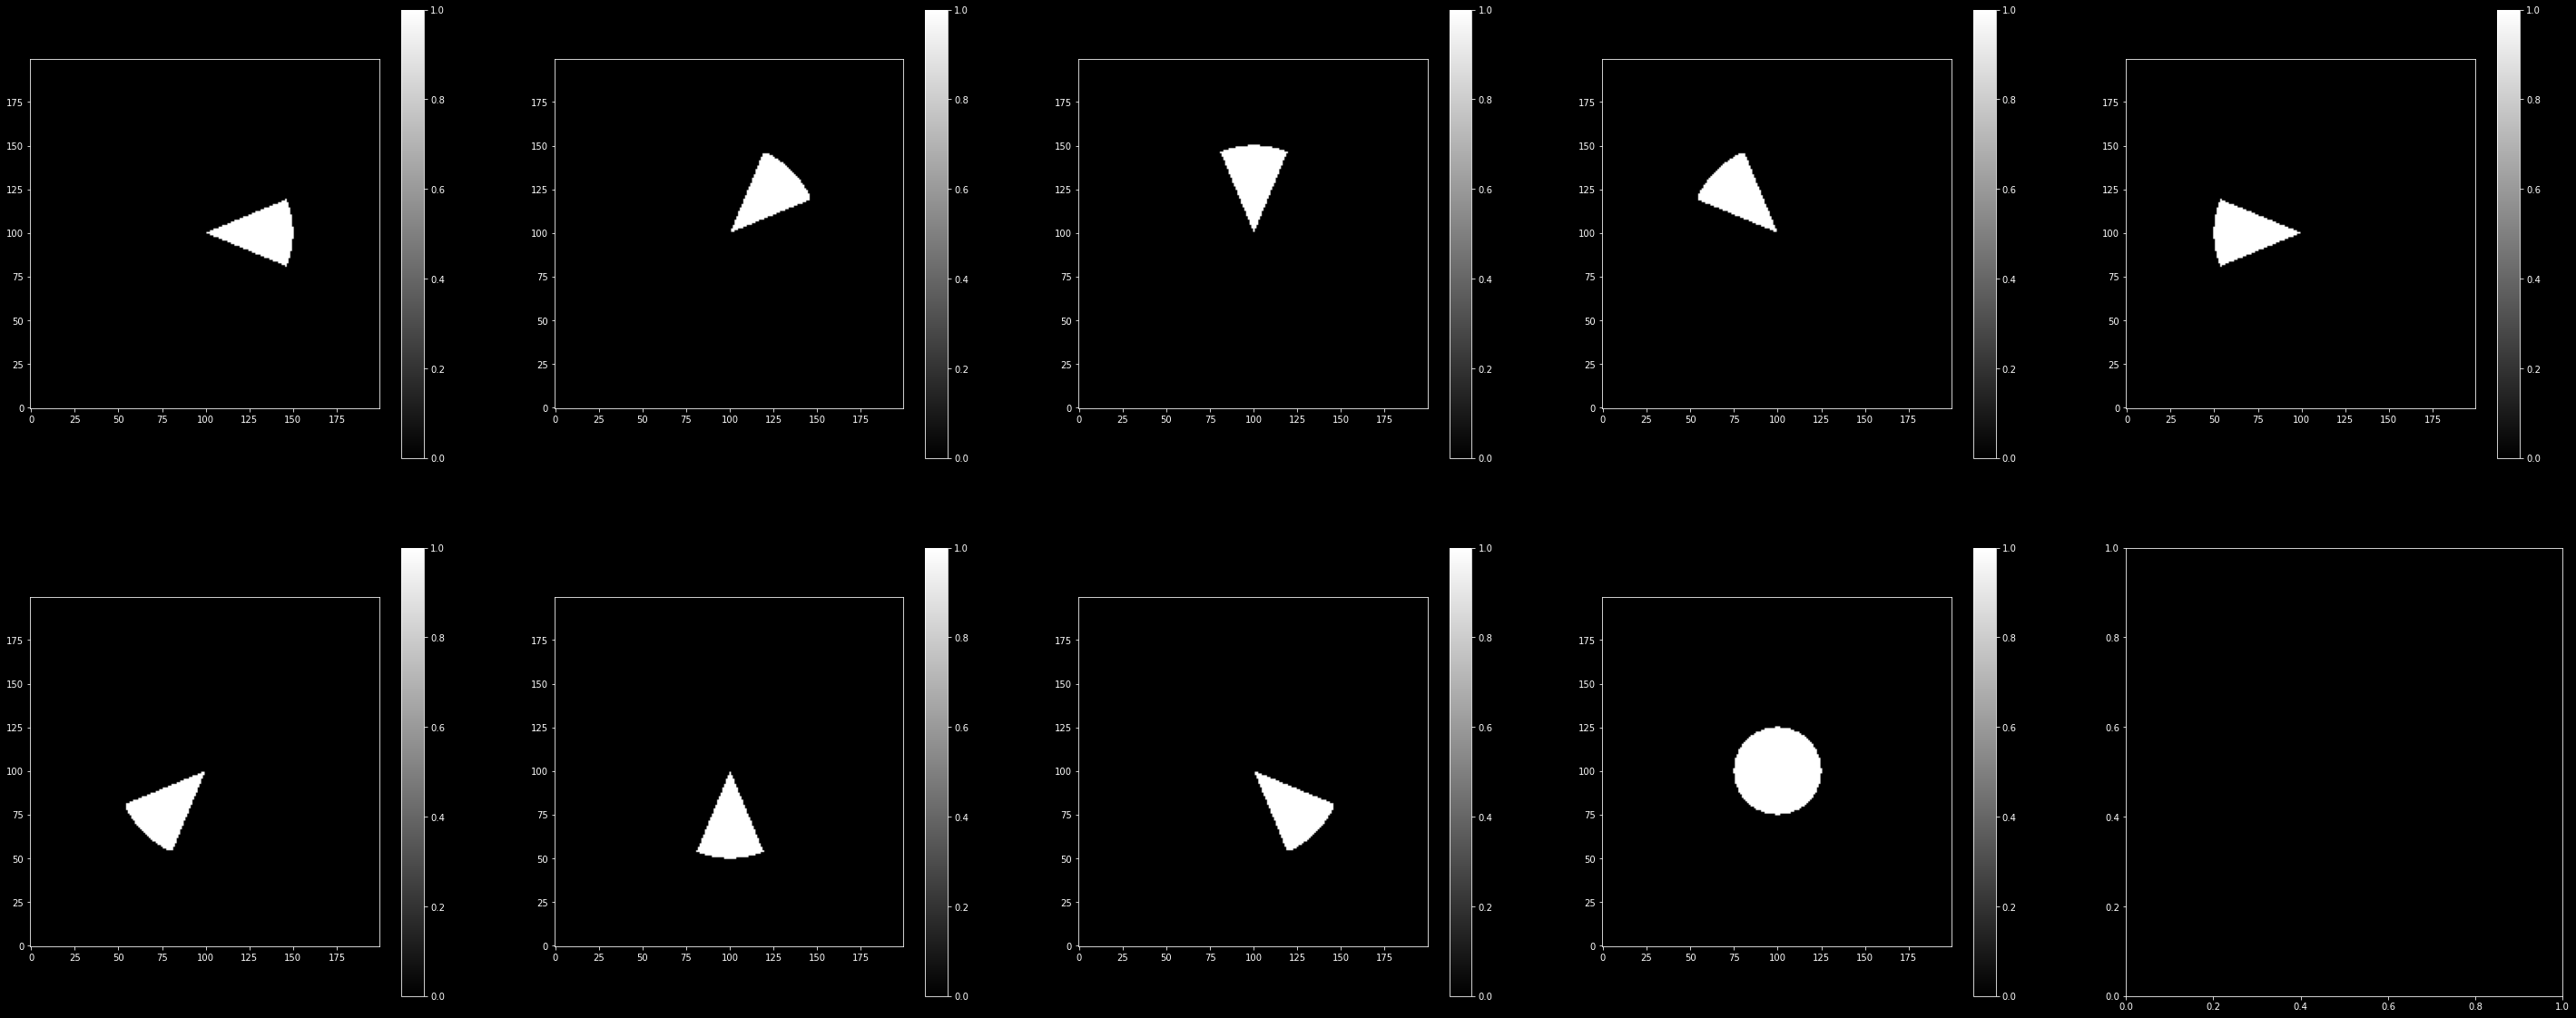

In [6]:
wo.plot_multicolumn(fftshift(Source_cont,axes=(1,2)), origin='lower', num_col=5)

## Reconstruct Stokes parameters

In [9]:
_, _, N, M, L = I_meas.shape
cali        = False               
bg_option   = 'global'            
use_gpu = True
gpu_id = 0

# chi = pi/2

A_matrix = 0.5*np.array([[1, 1, 0], \
                         [1, 0, 1], \
                         [1, -1, 0], \
                         [1, 0, -1]])


setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media=n_media, cali=cali, phase_deconv='3D', \
                                A_matrix=A_matrix, inc_recon='3D', \
                                illu_mode='Arbitrary', Source = Source_cont, Source_PolState=Source_PolState,\
                                use_gpu=use_gpu, gpu_id=gpu_id)


### Visualize high-dimensional Stokes arrays (polarization, illumination, x, y, z)

In [15]:
S_image_recon = setup.Stokes_recon(I_meas)

S_image_tm = np.zeros_like(S_image_recon)

S_bg_mean_0 = np.mean(S_image_recon[0,:,:,:,:], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
S_bg_mean_1 = np.mean(S_image_recon[1,:,:,:,:], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
S_bg_mean_2 = np.mean(S_image_recon[2,:,:,:,:], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]


S_image_tm[0] = S_image_recon[0]/S_bg_mean_0-1
S_image_tm[1] = S_image_recon[1]/S_bg_mean_0 - S_bg_mean_1*S_image_recon[0]/S_bg_mean_0**2
S_image_tm[2] = S_image_recon[2]/S_bg_mean_0 - S_bg_mean_2*S_image_recon[0]/S_bg_mean_0**2

In [24]:
# browse raw intensity stacks (stack_idx_1: z index, stack_idx2: pattern index)
wo.parallel_5D_viewer(np.transpose(I_meas,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [25]:
# browse uncorrected Stokes parameters (stack_idx_1: z index, stack_idx2: pattern index)
wo.parallel_5D_viewer(np.transpose(S_image_recon,(4,1,0,2,3)), num_col=4, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [26]:
# browse corrected Stokes parameters (stack_idx_1: z index, stack_idx2: pattern index)
wo.parallel_5D_viewer(np.transpose(S_image_tm,(4,1,0,2,3)), num_col=5, size=5, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

## 3D uPTI reconstruction

### 3D volumes of the components of scattering potential tensor

In [16]:
# Regularization parameters.
reg_inc = np.array([1, 1, 5e1, 5e1, 2.5e1, 2.5e1, 5e1])*1

reg_ret_pr = 1e-2


f_tensor = setup.scattering_potential_tensor_recon_3D_vec(S_image_tm, reg_inc=reg_inc)

Finished preprocess, elapsed time: 10.92
Finished reconstruction, elapsed time: 35.22


In [27]:
# browse the z-stack of components of scattering potential tensor
wo.parallel_4D_viewer(np.transpose(f_tensor,(3,0,1,2)), num_col=4, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### 3D volumes of principal retardance, 3D orientation, and optic sign 

|  20  |  2.55e+08  |   128.36   |
Finish optic sign estimation, elapsed time: 128.45


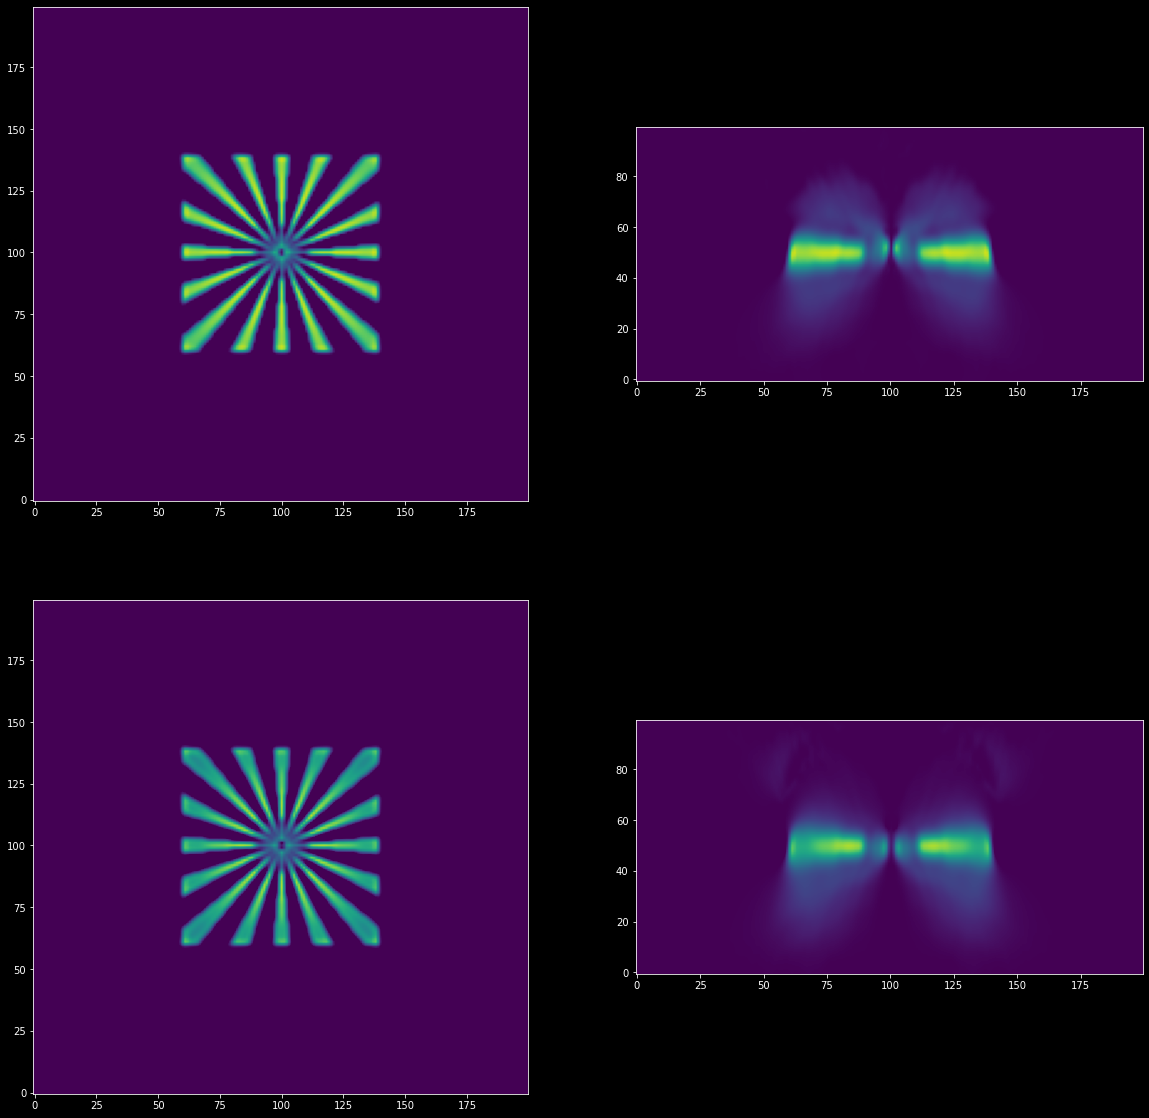

In [28]:
# reconstruct 3D anisotropy (principal retardance, 3D orientation, optic sign probability)
# material type: 
# "positive" -> only solution of positively uniaxial material
# "negative" -> only solution of negatively uniaxial meterial
# "unknown" -> both solutions of positively and negatively uniaxial material + optic sign estimation

retardance_pr, azimuth, theta, mat_map = setup.scattering_potential_tensor_to_3D_orientation(f_tensor, S_image_tm,\
                                                                                             material_type='unknown', reg_ret_pr = reg_ret_pr, itr=20, step_size=0.1)

In [20]:
# clean up GPU memory leftorver

import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [21]:
# scaling to the physical properties of the material

# optic sign probability
mat_map_thres = 0.2
mat_map_norm = mat_map / np.max(np.abs(np.sum(mat_map,axis=0)))
p_mat_map = np.maximum(mat_map_norm[0],mat_map_thres)/(np.maximum(mat_map_norm[0],mat_map_thres) + np.maximum(mat_map_norm[1],mat_map_thres))

# absorption and phase
absorption = f_tensor[1]/(4*np.pi/lambda_illu*n_media)*psz
phase = -f_tensor[0]/(4*np.pi/lambda_illu*n_media)*psz

# principal retardance (with some wavelet denoising)
retardance_pr_nm = retardance_pr/(2*np.pi/lambda_illu*n_media)*psz/2/np.pi*lambda_illu*1e3



In [22]:
# browse the reconstructed physical properties
wo.parallel_4D_viewer(np.transpose(np.stack([phase, retardance_pr_nm[0], azimuth[0], theta[0], \
                                             p_mat_map, retardance_pr_nm[1], azimuth[1], theta[1]]),(3,0,1,2)), num_col=4, origin='lower')

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### Visualization of 3D reconstruction

In [29]:
# create color-coded orientation images

ret_min_color = 0
ret_max_color = 0.3

orientation_3D_image = np.transpose(np.array([azimuth[0]/2/np.pi, theta[0], (np.clip(np.abs(retardance_pr_nm[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]),(3,1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


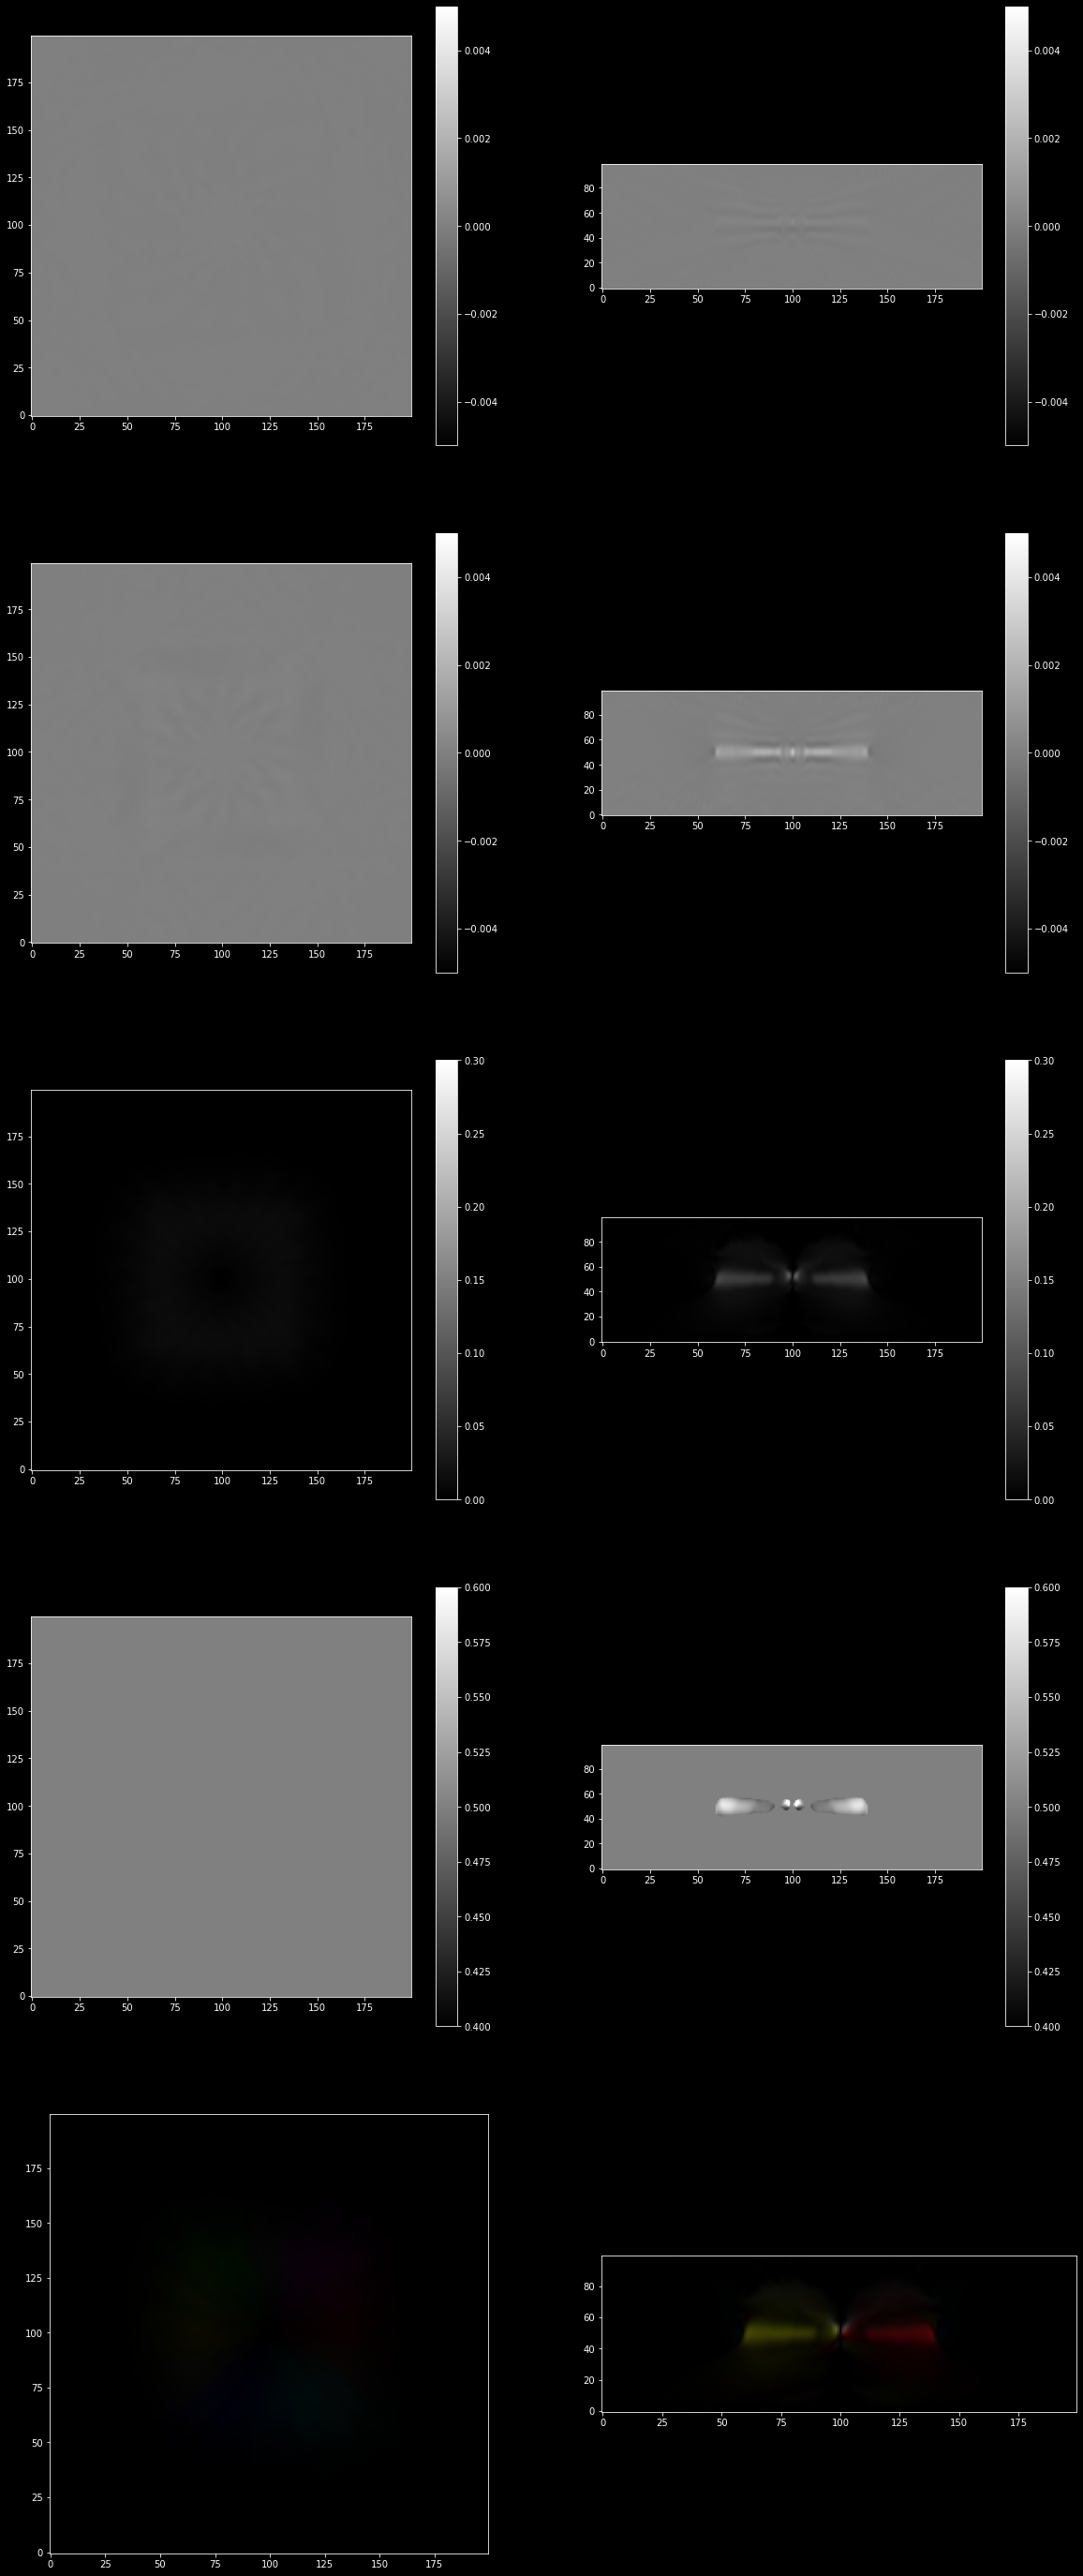

In [30]:
z_layer = 25
y_layer = 100
x_layer = 100
phase_min = -0.005
phase_max = 0.005
ret_min = 0
ret_max = 0.3
p_min = 0.4
p_max = 0.6
abs_min = -0.005
abs_max = 0.005

fig,ax = plt.subplots(5,2,figsize=(20,50))
sub_ax = ax[0,0].imshow(absorption[:,:,z_layer], cmap='gray', origin='lower', vmin=abs_min, vmax=abs_max)
plt.colorbar(sub_ax, ax=ax[0,0])
sub_ax = ax[0,1].imshow(np.transpose(absorption[y_layer,:,:]), cmap='gray', origin='lower',vmin=abs_min, vmax=abs_max,aspect=psz/ps)
plt.colorbar(sub_ax, ax=ax[0,1])
sub_ax = ax[1,0].imshow(phase[:,:,z_layer], cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
plt.colorbar(sub_ax, ax=ax[1,0])
sub_ax = ax[1,1].imshow(np.transpose(phase[y_layer,:,:]), cmap='gray', origin='lower',vmin=phase_min, vmax=phase_max,aspect=psz/ps)
plt.colorbar(sub_ax, ax=ax[1,1])
sub_ax = ax[2,0].imshow(np.abs(retardance_pr_nm[0,:,:,z_layer]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
plt.colorbar(sub_ax, ax=ax[2,0])
sub_ax = ax[2,1].imshow(np.transpose(np.abs(retardance_pr_nm[0,y_layer,:,:])), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max,aspect=psz/ps)
plt.colorbar(sub_ax, ax=ax[2,1])

sub_ax = ax[3,0].imshow(np.abs(p_mat_map[:,:,z_layer]), cmap='gray', origin='lower',vmin=p_min, vmax=p_max)
plt.colorbar(sub_ax, ax=ax[3,0])
sub_ax = ax[3,1].imshow(np.transpose(np.abs(p_mat_map[y_layer,:,:])), cmap='gray', origin='lower',vmin=p_min, vmax=p_max, aspect=psz/ps)
plt.colorbar(sub_ax, ax=ax[3,1])

sub_ax = ax[4,0].imshow(orientation_3D_image_RGB[z_layer,:,:], origin='lower')
sub_ax = ax[4,1].imshow(orientation_3D_image_RGB[:,y_layer,:], origin='lower', aspect=psz/ps)

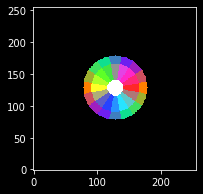

In [165]:
# plot the top view of 3D orientation colorsphere
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1, discretize=True)

## Evaluation of reconstructed 3D orientation

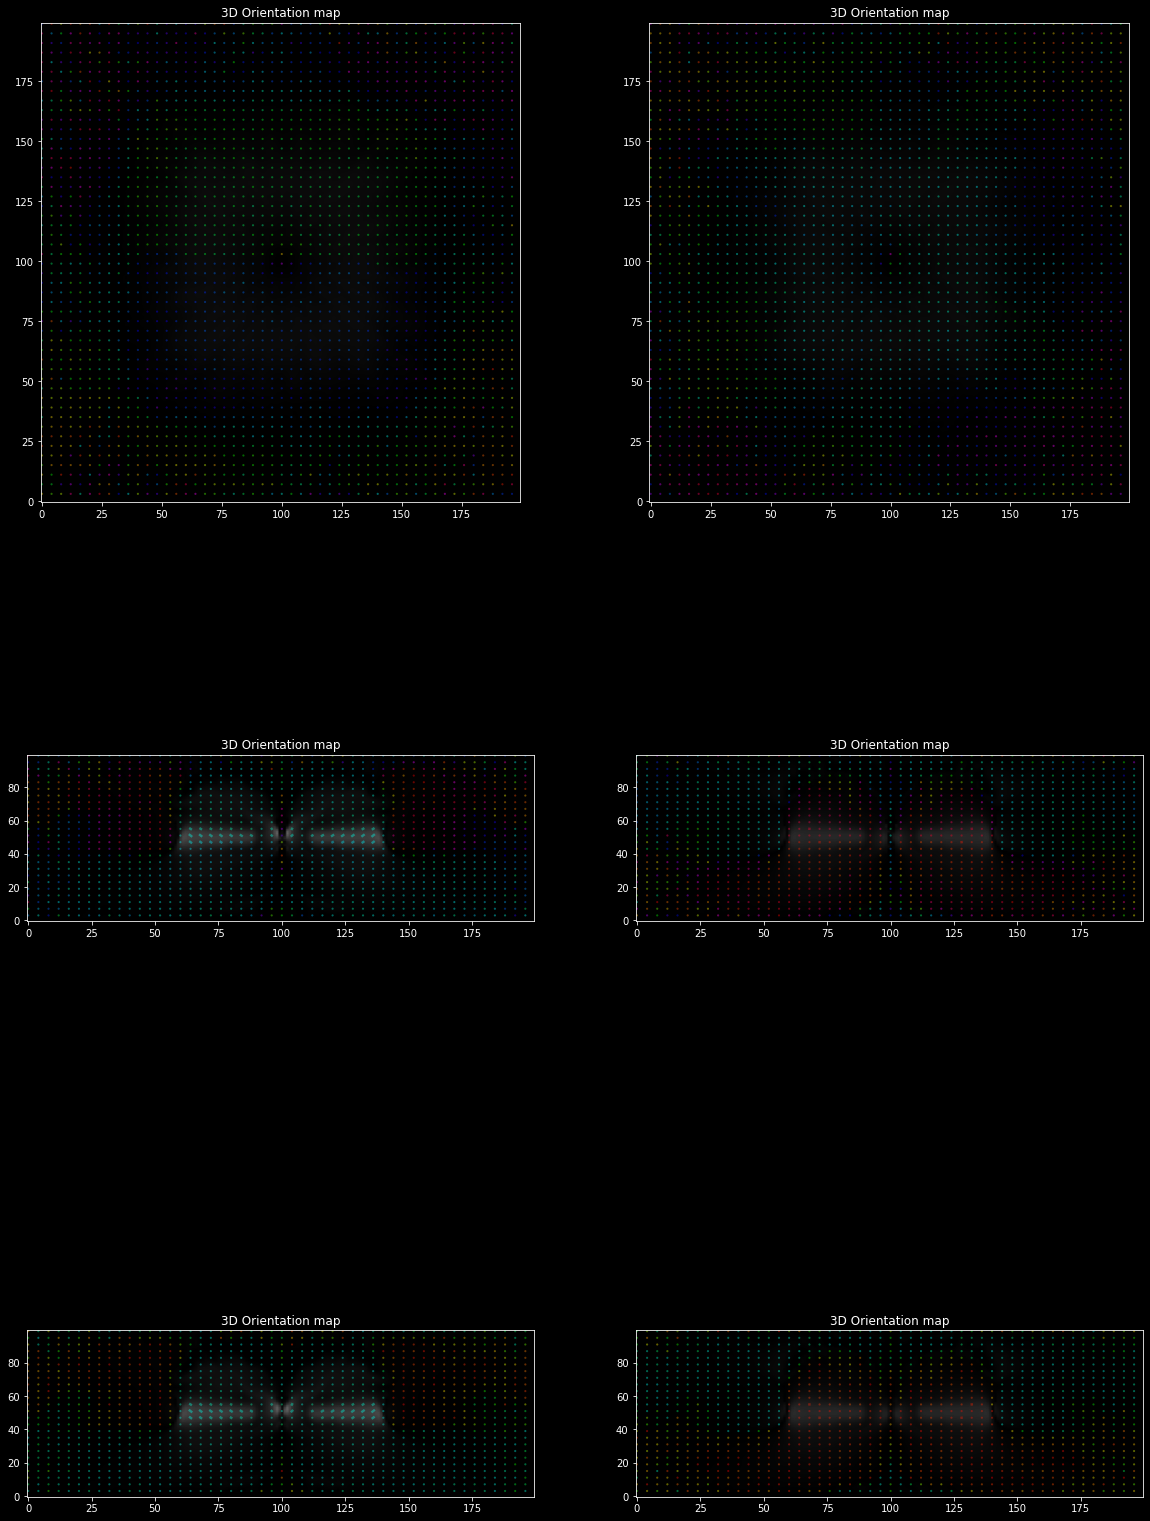

In [31]:
vect = np.zeros((3,)+azimuth.shape)
vect[0] = np.sin(theta)*np.cos(azimuth)
vect[1] = np.sin(theta)*np.sin(azimuth)
vect[2] = np.cos(theta)

theta_x = np.arccos(vect[0])
azimuth_x = np.arctan2(vect[2], vect[1])

theta_y = np.arccos(vect[1])
azimuth_y = np.arctan2(vect[2], vect[0])

z_step = psz
spacing = 4
z_layer =  25
x_layer = 100
y_layer = 100


# plt.figure(figsize=(10,10))

fig,ax = plt.subplots(3,2,figsize=(20,30))
wo.plot3DVectorField(np.abs(retardance_pr_nm[0,:,:,z_layer]), azimuth[0,:,:,z_layer], theta[0,:,:,z_layer], 
                     anisotropy=0.4*np.abs(retardance_pr_nm[0,:,:,z_layer]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=spacing, linelength=spacing*2, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[0,0])
wo.plot3DVectorField(np.abs(retardance_pr_nm[1,:,:,z_layer]), azimuth[1,:,:,z_layer], theta[1,:,:,z_layer], 
                     anisotropy=0.4*np.abs(retardance_pr_nm[1,:,:,z_layer]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=spacing, linelength=spacing*2, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[0,1])

wo.plot3DVectorField(np.transpose(np.abs(retardance_pr_nm[0,:,x_layer,:])), np.transpose(azimuth_x[0,:,x_layer,:]), np.transpose(theta_x[0,:,x_layer,:]), 
                     anisotropy=0.4*np.transpose(np.abs(retardance_pr_nm[0,:,x_layer,:])), cmapImage='gray', clim=[ret_min, ret_max], aspect=z_step/ps, 
                     spacing=spacing, window=spacing, linelength=spacing*2, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[1,0])

wo.plot3DVectorField(np.transpose(np.abs(retardance_pr_nm[1,:,x_layer,:])), np.transpose(azimuth_x[1,:,x_layer,:]), np.transpose(theta_x[1,:,x_layer,:]), 
                     anisotropy=0.4*np.transpose(np.abs(retardance_pr_nm[1,:,x_layer,:])), cmapImage='gray', clim=[ret_min, ret_max], aspect=z_step/ps, 
                     spacing=spacing, window=spacing, linelength=spacing*2, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[1,1])

wo.plot3DVectorField(np.transpose(np.abs(retardance_pr_nm[0,y_layer,:,:])), np.transpose(azimuth_y[0,y_layer,:,:]), np.transpose(theta_y[0,y_layer,:,:]),
                     anisotropy=0.4*np.transpose(np.abs(retardance_pr_nm[0,y_layer,:,:])), cmapImage='gray', clim=[ret_min, ret_max], aspect=z_step/ps, 
                     spacing=spacing, window=spacing, linelength=spacing*2, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[2,0])

wo.plot3DVectorField(np.transpose(np.abs(retardance_pr_nm[1,y_layer,:,:])), np.transpose(azimuth_y[1,y_layer,:,:]), np.transpose(theta_y[1,y_layer,:,:]),
                     anisotropy=0.4*np.transpose(np.abs(retardance_pr_nm[1, y_layer,:,:])), cmapImage='gray', clim=[ret_min, ret_max], aspect=z_step/ps, 
                     spacing=spacing, window=spacing, linelength=spacing*2, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[2,1])



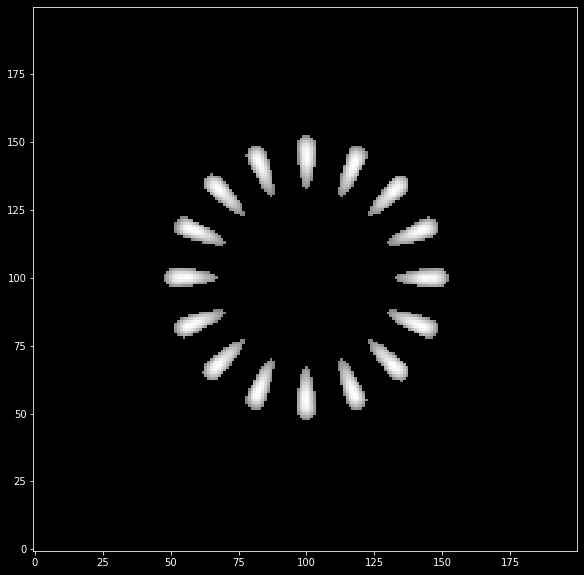

In [167]:
ret_mask = np.abs(retardance_pr_nm[0]).copy()
ret_mask[ret_mask<0.15]=0
# ret_mask[:,:,:50]=0

plt.figure(figsize=(10,10))
plt.imshow(ret_mask[:,:,z_layer], cmap='gray', origin='lower')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x7ffc3d8901d0>)

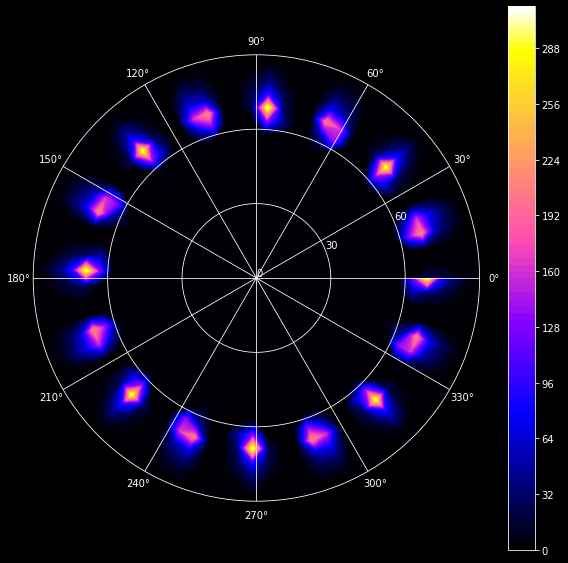

In [168]:
# Angular histogram of 3D orientation

wo.orientation_3D_hist(azimuth[0].flatten(), \
                       theta[0].flatten(), \
                       ret_mask.flatten(),\
                       bins=36, num_col=1, size=10, contour_level = 100, hist_cmap='gnuplot2', top_hemi=True)

Text(0.5, 1.0, 'recon')

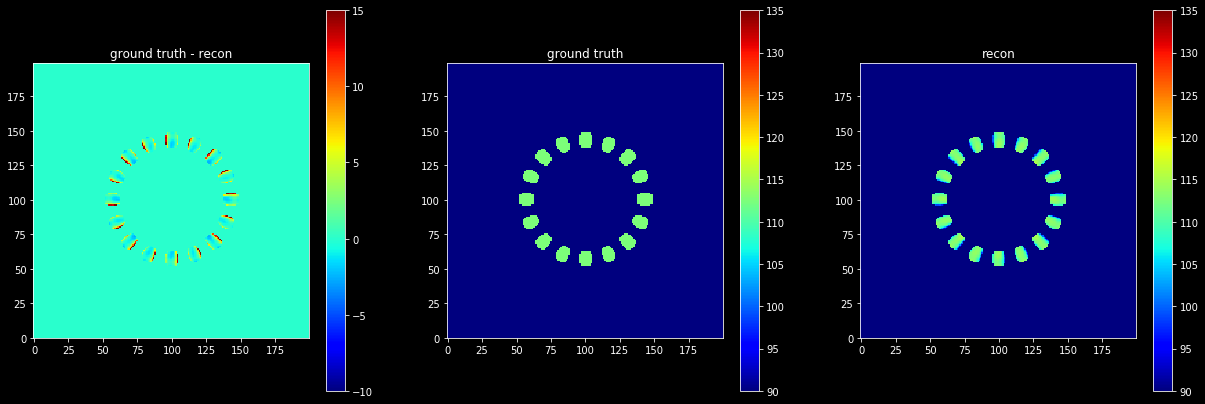

In [154]:
blur_size = 1*ps
# target, azimuth_t, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size, inc_upper_bound=np.pi/4, inc_range=np.pi/64)
target, azimuth_t, inc_angle = wo.genStarTarget_3D((N,M,L), ps, psz, blur_size)
inc_angle = np.round(inc_angle/np.pi*8)/8*np.pi
azimuth   = np.round(azimuth/np.pi/2*16)/16*np.pi*2
# inc_angle = (inc_angle-np.pi/2)*3+np.pi/2
# orientation = (((azimuth+np.pi/16*1)//(np.pi/8)*np.pi/8)-0*np.pi/12)%(2*np.pi)

mask = target.copy()
mask[mask>0.2] = 1
mask[mask<=0.2] = 0
# mask = np.ones_like(target)

fig, ax = plt.subplots(1,3,figsize=(21,7))
ax1 = ax[0].imshow((mask*(inc_angle-(np.abs(theta[0]-np.pi/2)+np.pi/2)))[:,:,25]/np.pi*180, cmap='jet', origin='lower', vmin=-10, vmax=15)
plt.colorbar(ax1,ax=ax[0])
ax2 = ax[1].imshow((mask*inc_angle)[:,:,25]/np.pi*180, cmap='jet', origin='lower', vmin=90, vmax=135)
plt.colorbar(ax2,ax=ax[1])
ax3 = ax[2].imshow((mask*(np.abs(theta[0]-np.pi/2)+np.pi/2))[:,:,25]/np.pi*180, cmap='jet', origin='lower',vmin=90, vmax=135)
plt.colorbar(ax3,ax=ax[2])


ax[0].set_title('ground truth - recon')
ax[1].set_title('ground truth')
ax[2].set_title('recon')


In [155]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [156]:
(np.sum((mask*(inc_angle-(np.abs(theta[0]-np.pi/2)+np.pi/2)))[:,:,25]**2)/np.sum(mask[:,:,25]))**0.5*180/np.pi

4.68795954497633